Great! Let's outline a **complete framework for your paper** based on your analyses — including EEG modeling with **Hopfield networks**, **Jansen-Rit model**, and **Advanced Energy Landscape (Ising)** features, followed by **statistical testing and machine learning**.

---

## 📝 Framework for Your Research Paper

### **1. Title (Tentative)**

> **"Decoding Neural Dynamics Using Energy-Based Models and Biophysical Simulations: A Comparative EEG Study"**

---

### **2. Abstract**

* **1–2 sentences on background**: Importance of understanding neural dynamics from EEG.
* **1 sentence on methods**: You use Hopfield, Jansen-Rit, and Ising-based energy landscape models.
* **1 sentence on novelty**: Combined analysis of attractor dynamics, biophysical parameters, and energy features.
* **1–2 key findings**: Features (e.g., Theta Min Energy) showed group-level trends and were predictive in ML.
* **1 sentence on significance**: Framework for integrating dynamical systems with ML for EEG analysis.

---

### **3. Introduction**

* **EEG and the challenge**: EEG signals reflect large-scale neural dynamics but are noisy and complex.
* **Attractors in the brain**: Brief intro to attractor networks, Hopfield models, and energy landscapes.
* **Jansen-Rit model**: How it biophysically models cortical columns.
* **Motivation**: Combining multiple modeling approaches can reveal distinct aspects of neural organization.
* **Objective**: Evaluate and compare extracted features across groups (Good vs Bad counters), and assess their discriminative power.

---

### **4. Methods**

#### 4.1 Dataset & Preprocessing

* Description of dataset
* EEG preprocessing (bandpass filtering, epoching)
* Rest vs Task conditions
* Good/Bad label criteria

#### 4.2 Modeling Approaches

**4.2.1 Hopfield Network**

* Binary representation of EEG
* Hebbian learning
* Extraction of: number of attractors, basin size, energy, entropy

**4.2.2 Jansen-Rit Neural Mass Model**

* Parameters A, B, C, μ fitted to alpha-band envelope using DE optimization
* Model simulates pyramidal output
* Extracted: parameter values + loss

**4.2.3 Ising Energy Landscape**

* Constructed from binary states
* Identification of energy minima
* Extracted: number of minima, min/max/mean energy, entropy, energy range

#### 4.3 Feature Extraction & Labeling

* Flattened subject-wise feature dictionaries
* Labeling: Good vs Bad
* Features grouped by domain (Hopfield, JR, Ising)

#### 4.4 Statistical Comparison

* t-tests / Mann-Whitney U tests
* Visualizations (boxplots, heatmaps)
* Significance threshold (e.g., p < 0.05)

#### 4.5 Machine Learning Classification

* Models used: Logistic Regression, Random Forest, SVM, XGBoost
* Feature scaling, SMOTE for balancing
* Evaluation: Accuracy, F1-macro, confusion matrix

---

### **5. Results**

#### 5.1 Descriptive Statistics

* Table of group means for each feature
* Highlight interesting differences (e.g., Theta Min Energy, Rit C)

#### 5.2 Statistical Significance

* Chart of p-values (e.g., Hopfield features heatmap)
* Note features with p < 0.3 or effect trends

#### 5.3 Machine Learning

* Best-performing model (e.g., XGBoost)
* Performance before & after SMOTE
* Top 10 features by importance
* ROC or confusion matrix

---

### **6. Discussion**

* Interpret key features: Why do Theta energies differ? What does Rit μ tell us?
* Integration of results: Hopfield shows attractor-level behavior; JR shows synaptic gain differences; Ising shows global minima shifts.
* Why combining models helps?
* Limitations: Sample size, binary classification, EEG noise
* Future work: Multimodal validation, use of dynamic features, attention to temporal aspects

---

### **7. Conclusion**

* Summary of methods and findings
* Contribution: A multi-model feature extraction pipeline for EEG
* Potential: Biomarker discovery, mental state classification

---

### **8. References**

* Include references to:

  * Hopfield networks
  * Jansen-Rit model
  * Ising models in neuroscience
  * EEG machine learning applications
  * Your tools/libraries used (e.g., PyMC, MNE)

---

### **9. Appendix / Supplementary (if needed)**

* Detailed parameter ranges
* Optimization settings
* Full classification reports
* Subject-wise statistics

---

## ✅ Next Steps

Would you like me to:

1. Start writing a **specific section** (e.g., Methods or Abstract)?
2. Generate **figures/tables** for Results?
3. Convert this structure into a **LaTeX or Word-compatible template**?
4. Draft a **title and abstract** for submission?

Let me know how you'd like to proceed.


In [73]:
%matplotlib inline

In [74]:
import pickle
import mne
import numpy as np
from collections import Counter
import networkx as nx
from collections import defaultdict
from sklearn.manifold import SpectralEmbedding
import matplotlib.pyplot as plt
import matplotlib
import pickle
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy
from sklearn.decomposition import PCA
import seaborn as sns
import pathlib
from tqdm import tqdm

In [75]:
#matplotlib.use('Qt5Agg')

In [76]:
# Load the raw EEG task data (already stored as a dict of Raw objects)
with open("/home/donaf-strange/LAB_WORK/eeg_arithmetic_project/data/all_rest_eeg_by_participant.pkl", 'rb') as f:
    task_eeg_dict = pickle.load(f)

# Container for preprocessed EEG
preprocessed_task_eeg = {}

for i in tqdm(range(36)):
    subj_id = str(i)
    if subj_id not in task_eeg_dict:
        print(f"⚠️ Subject {subj_id} not found.")
        continue

    raw = task_eeg_dict[subj_id].copy()  # don’t modify original
    raw.set_eeg_reference('average', verbose='error')
    raw.filter(1., 45., fir_design='firwin', verbose='error')
    
    preprocessed_task_eeg[subj_id] = raw

# ✅ Save preprocessed EEG for future steps
with open("preprocessed_task_eeg.pkl", "wb") as f:
    pickle.dump(preprocessed_task_eeg, f)

print("✅ Step 1 complete: Task EEG preprocessed and saved.")

100%|██████████| 36/36 [00:07<00:00,  4.53it/s]


✅ Step 1 complete: Task EEG preprocessed and saved.


In [77]:
# Load preprocessed EEG
with open("preprocessed_task_eeg.pkl", "rb") as f:
    preprocessed_task_eeg = pickle.load(f)

# Container for binarized data
binarized_task_data = {}

# Threshold type: 'median', 'mean', or later quantiles
threshold_type = 'median'

for subj_id, raw in tqdm(preprocessed_task_eeg.items()):
    data = raw.get_data()  # shape: (n_channels, n_times)

    # Compute thresholds per channel
    if threshold_type == 'median':
        thresholds = np.median(data, axis=1, keepdims=True)
    elif threshold_type == 'mean':
        thresholds = np.mean(data, axis=1, keepdims=True)
    else:
        raise ValueError("Unsupported threshold type.")

    # Binarize: 1 if above threshold, 0 otherwise
    binarized = (data > thresholds).astype(int)

    binarized_task_data[subj_id] = binarized

# Save binarized task EEG
with open("binarized_task_data.pkl", "wb") as f:
    pickle.dump(binarized_task_data, f)

print("✅ Step 2 complete: Binarized EEG saved.")

100%|██████████| 36/36 [00:02<00:00, 15.68it/s]


✅ Step 2 complete: Binarized EEG saved.


In [78]:
# Load binarized task EEG
with open("binarized_task_data.pkl", "rb") as f:
    binarized_task_data = pickle.load(f)

# Store per subject
task_subject_states = {}
task_subject_energies = {}

for subj_id, bin_data in tqdm(binarized_task_data.items()):
    n_channels, n_times = bin_data.shape

    # Convert each time point to a binary state string
    # Example: [0,1,0,1] -> '0101'
    state_strings = [''.join(bin_data[:, t].astype(str)) for t in range(n_times)]

    # Count frequency of each unique state
    state_counts = Counter(state_strings)

    total_states = sum(state_counts.values())
    state_probs = {s: c / total_states for s, c in state_counts.items()}

    # Energy = -log(P)
    state_energies = {s: -np.log(p) for s, p in state_probs.items()}

    task_subject_states[subj_id] = state_counts
    task_subject_energies[subj_id] = state_energies

# Save for later steps
with open("task_subject_states.pkl", "wb") as f:
    pickle.dump(task_subject_states, f)

with open("task_subject_energies.pkl", "wb") as f:
    pickle.dump(task_subject_energies, f)

print("✅ Step 3 complete: Extracted states and computed energies.")

100%|██████████| 36/36 [00:28<00:00,  1.25it/s]


✅ Step 3 complete: Extracted states and computed energies.


In [79]:
# Load state and energy data
with open("task_subject_states.pkl", "rb") as f:
    task_subject_states = pickle.load(f)

with open("task_subject_energies.pkl", "rb") as f:
    task_subject_energies = pickle.load(f)

# Store minima and basins per subject
task_local_minima = {}
task_basin_sizes = {}

for subj_id in tqdm(task_subject_energies):
    state_energies = task_subject_energies[subj_id]

    # Convert binary string states to binary vectors
    state_vectors = np.array([list(map(int, s)) for s in state_energies.keys()])
    energy_values = np.array(list(state_energies.values()))
    state_keys = list(state_energies.keys())

    # PCA projection to 2D for locality
    pca = PCA(n_components=2)
    projected = pca.fit_transform(state_vectors)

    # Find local minima: states with lower energy than all neighbors in 2D
    from scipy.spatial import KDTree
    tree = KDTree(projected)
    local_minima = []

    for i, vec in enumerate(projected):
        dists, idxs = tree.query(vec, k=6)  # 5 neighbors + self
        neighbors = energy_values[idxs]
        if energy_values[i] == np.min(neighbors):
            local_minima.append(i)

    minima_states = [state_keys[i] for i in local_minima]

    # Basin size: count how many states flow into each minimum
    basin_sizes = {s: 0 for s in minima_states}

    for s in state_keys:
        energy = state_energies[s]
        s_vec = np.array(list(map(int, s)))
        s_proj = pca.transform([s_vec])[0]
        dists, idxs = tree.query(s_proj, k=6)
        neighbors = [(state_keys[j], energy_values[j]) for j in idxs]
        min_neighbor = min(neighbors, key=lambda x: x[1])[0]

        if min_neighbor in basin_sizes:
            basin_sizes[min_neighbor] += 1

    # Save
    task_local_minima[subj_id] = minima_states
    task_basin_sizes[subj_id] = basin_sizes

# Save results
with open("task_local_minima.pkl", "wb") as f:
    pickle.dump(task_local_minima, f)

with open("task_basin_sizes.pkl", "wb") as f:
    pickle.dump(task_basin_sizes, f)

print("✅ Step 4 complete: Local minima and basin sizes stored.")

100%|██████████| 36/36 [02:12<00:00,  3.68s/it]

✅ Step 4 complete: Local minima and basin sizes stored.


In [80]:
# Load binarized task EEG
with open("binarized_task_data.pkl", "rb") as f:
    binarized_task_data = pickle.load(f)

task_entropy = {}
task_hub_state = {}
task_transition_matrices = {}

for subj_id, bin_data in tqdm(binarized_task_data.items()):
    n_channels, n_times = bin_data.shape

    # Convert each time point into a binary string
    state_sequence = [''.join(bin_data[:, t].astype(str)) for t in range(n_times)]

    # Build transition count matrix
    transitions = defaultdict(Counter)
    for i in range(len(state_sequence) - 1):
        current = state_sequence[i]
        next_state = state_sequence[i + 1]
        transitions[current][next_state] += 1

    # Normalize to get transition probabilities
    transition_probs = {}
    for s_from, targets in transitions.items():
        total = sum(targets.values())
        transition_probs[s_from] = {s_to: count / total for s_to, count in targets.items()}

    # Compute transition entropy for each state
    entropy_values = []
    for s_from, probs in transition_probs.items():
        entropy = -sum(p * np.log2(p) for p in probs.values())
        entropy_values.append(entropy)

    mean_entropy = np.mean(entropy_values) if entropy_values else 0

    # Determine the hub state (most visited)
    state_counts = Counter(state_sequence)
    hub_state = state_counts.most_common(1)[0][0]

    # Store results
    task_entropy[subj_id] = mean_entropy
    task_hub_state[subj_id] = hub_state
    task_transition_matrices[subj_id] = transition_probs

# Save results
with open("task_entropy.pkl", "wb") as f:
    pickle.dump(task_entropy, f)

with open("task_hub_state.pkl", "wb") as f:
    pickle.dump(task_hub_state, f)

with open("task_transition_matrices.pkl", "wb") as f:
    pickle.dump(task_transition_matrices, f)

print("✅ Step 5 complete: Transition entropy and hub states saved.")

100%|██████████| 36/36 [00:31<00:00,  1.14it/s]


✅ Step 5 complete: Transition entropy and hub states saved.


In [81]:
# Load binarized task EEG data
with open("binarized_task_data.pkl", "rb") as f:
    binarized_task_data = pickle.load(f)

task_state_coords = {}

for subj_id, bin_data in tqdm(binarized_task_data.items()):
    n_channels, n_times = bin_data.shape

    # Convert each time point into a binary vector string
    states = [''.join(bin_data[:, t].astype(str)) for t in range(n_times)]

    # Convert to unique binary vectors (as float array)
    unique_state_strs = sorted(set(states))
    unique_state_vectors = np.array([list(map(int, list(s))) for s in unique_state_strs])  # shape: (n_unique_states, 21)

    # PCA to 2D
    pca = PCA(n_components=2)
    coords = pca.fit_transform(unique_state_vectors)

    task_state_coords[subj_id] = coords

# Save for plotting
with open("task_state_coords.pkl", "wb") as f:
    pickle.dump(task_state_coords, f)

print("✅ Generated and saved task_state_coords.pkl for Step 6 visualization.")


100%|██████████| 36/36 [00:29<00:00,  1.20it/s]


✅ Generated and saved task_state_coords.pkl for Step 6 visualization.


# Load binarized task EEG data
with open("binarized_task_data.pkl", "rb") as f:
    binarized_task_data = pickle.load(f)

task_energy_landscapes = {}
task_transition_matrices = {}

for subj_id, binarized in tqdm(binarized_task_data.items()):
    n_channels, n_times = binarized.shape

    # Convert each state (column) to an integer for tracking
    states = np.packbits(binarized.T, axis=1, bitorder='little').flatten()
    unique_states, counts = np.unique(states, return_counts=True)
    state_probs = counts / np.sum(counts)

    # Transition matrix: count transitions between consecutive states
    transitions = list(zip(states[:-1], states[1:]))
    trans_counts = Counter(transitions)

    n_states = 2 ** n_channels  # Full state space size (will trim later)
    P = np.zeros((n_states, n_states))

    for (s1, s2), count in trans_counts.items():
        P[s1, s2] = count

    # Normalize rows
    row_sums = P.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    P /= row_sums

    # Energy = -log(probability)
    probs_full = np.zeros(n_states)
    probs_full[unique_states] = state_probs
    with np.errstate(divide='ignore'):
        energy = -np.log(probs_full)
    energy[np.isinf(energy)] = np.nanmax(energy[np.isfinite(energy)]) + 1  # Handle zero-prob states

    # Local minima detection (Hamming neighbors)
    local_minima = []
    basin_sizes = []

    for s in unique_states:
        bin_s = np.array(list(np.binary_repr(s, width=n_channels))).astype(int)
        neighbors = []
        for i in range(n_channels):
            flip = bin_s.copy()
            flip[i] = 1 - flip[i]
            neighbors.append(int("".join(flip.astype(str)), 2))
        if all(energy[s] < energy[n] for n in neighbors if probs_full[n] > 0):
            local_minima.append(s)

    for min_state in local_minima:
        basin_sizes.append(np.sum([1 for state in states if state == min_state]))

    # Save results
    task_energy_landscapes[subj_id] = {
        "energy_values": energy,
        "local_minima": local_minima,
        "basin_sizes": basin_sizes,
    }
    task_transition_matrices[subj_id] = P

# Save to file
with open("task_energy_landscapes.pkl", "wb") as f:
    pickle.dump(task_energy_landscapes, f)

with open("task_transition_matrices.pkl", "wb") as f:
    pickle.dump(task_transition_matrices, f)

print("✅ Energy landscapes and transition matrices saved for task data.")



In [83]:
# Load binarized task EEG data
with open("binarized_task_data.pkl", "rb") as f:
    binarized_task_data = pickle.load(f)

task_energy_landscapes = {}
task_transition_matrices = {}

for subj_id, binarized in tqdm(binarized_task_data.items()):
    n_channels, n_times = binarized.shape

    # Convert binary vector to integer per timepoint
    states = np.packbits(binarized.T, axis=1, bitorder='little').flatten()

    # Compute transition counts (observed transitions only)
    transitions = list(zip(states[:-1], states[1:]))
    trans_counts = Counter(transitions)

    # Compute state probabilities
    state_counts = Counter(states)
    total_states = sum(state_counts.values())
    state_probs = {k: v / total_states for k, v in state_counts.items()}

    # Compute energy = -log(probability)
    energies = {state: -np.log(prob) for state, prob in state_probs.items()}

    # Estimate local minima: a state is a local minimum if it has lower energy than all Hamming-1 neighbors
    local_minima = []
    for state in state_probs:
        s_bin = np.array(list(np.binary_repr(state, width=n_channels))).astype(int)
        is_min = True
        for i in range(n_channels):
            neighbor = s_bin.copy()
            neighbor[i] ^= 1  # flip bit
            neighbor_int = int("".join(neighbor.astype(str)), 2)
            if neighbor_int in energies and energies[state] >= energies[neighbor_int]:
                is_min = False
                break
        if is_min:
            local_minima.append(state)

    # Basin size: how many times each minima occurred
    basin_sizes = {m: state_counts.get(m, 0) for m in local_minima}

    # Transition matrix (sparse)
    transition_matrix = defaultdict(dict)
    for (s1, s2), count in trans_counts.items():
        transition_matrix[s1][s2] = count

    # Normalize each row
    for s1 in transition_matrix:
        row_sum = sum(transition_matrix[s1].values())
        for s2 in transition_matrix[s1]:
            transition_matrix[s1][s2] /= row_sum

    # Save results
    task_energy_landscapes[subj_id] = {
        "energy_values": energies,
        "local_minima": local_minima,
        "basin_sizes": basin_sizes,
    }
    task_transition_matrices[subj_id] = transition_matrix

# Save to file
with open("task_energy_landscapes.pkl", "wb") as f:
    pickle.dump(task_energy_landscapes, f)

with open("task_transition_matrices.pkl", "wb") as f:
    pickle.dump(task_transition_matrices, f)

print("✅ Task data: Energy landscapes and transitions saved (memory-safe).")


100%|██████████| 36/36 [00:10<00:00,  3.27it/s]


✅ Task data: Energy landscapes and transitions saved (memory-safe).


In [84]:
# Load energy and transition data
with open("task_energy_landscapes.pkl", "rb") as f:
    task_energy_landscapes = pickle.load(f)

with open("task_transition_matrices.pkl", "rb") as f:
    task_transition_matrices = pickle.load(f)

# Define groups
bad_counters = ['Subject00', 'Subject04', 'Subject06', 'Subject09', 'Subject10', 
                'Subject14', 'Subject19', 'Subject21', 'Subject22', 'Subject30']

good_counters = ['Subject01', 'Subject02', 'Subject03', 'Subject05', 'Subject07', 'Subject08', 
                 'Subject11', 'Subject12', 'Subject13', 'Subject15', 'Subject16', 'Subject17', 
                 'Subject18', 'Subject20', 'Subject23', 'Subject24', 'Subject25', 'Subject26', 
                 'Subject27', 'Subject28', 'Subject29', 'Subject31', 'Subject32', 'Subject33',
                 'Subject34', 'Subject35']

'''bad_counters = ['0', '4', '6', '9', '10', 
                '14', '19', '21', '22', '30']

good_counters = ['1', '2', '3', '5', '7', '8', 
                 '11', '12', '13', '15', '16', '17', 
                 '18', '20', '23', '24', '25', '26', 
                 '27', '28', '29', '31', '32', '33', 
                 '34', '35']'''

# Containers for metrics
metrics = defaultdict(list)

for subj_id, landscape in task_energy_landscapes.items():
    subj_label = f"Subject{subj_id.zfill(2)}"
    #subj_label = subj_id.zfill(2)
    transition_matrix = task_transition_matrices.get(subj_id, {})

    if not transition_matrix:
        continue  # skip subjects with missing data

    energies = landscape["energy_values"]
    local_minima = landscape["local_minima"]
    basin_sizes = landscape["basin_sizes"]

    # Compute metrics
    n_minima = len(local_minima)
    mean_basin = np.mean(list(basin_sizes.values())) if basin_sizes else 0
    global_min = min(energies.values()) if energies else np.nan

    # Transition entropy
    entropy = 0
    for row in transition_matrix.values():
        probs = np.array(list(row.values()))
        entropy += -np.sum(probs * np.log2(probs + 1e-12))  # Avoid log(0)

    # Find hub node (most connected)
    flat_counts = defaultdict(int)
    for s1, neighbors in transition_matrix.items():
        for s2, p in neighbors.items():
            flat_counts[s2] += p
    hub_node = max(flat_counts, key=flat_counts.get)

    # Append metrics
    metrics['subject'].append(subj_label)
    metrics['group'].append('Bad' if subj_label in bad_counters else 'Good')
    metrics['n_minima'].append(n_minima)
    metrics['mean_basin'].append(mean_basin)
    metrics['global_min'].append(global_min)
    metrics['entropy'].append(entropy)
    metrics['hub_node'].append(hub_node)


print("✅ Group-level metrics for task data computed.")

# You can now visualize the metrics using boxplots or save them to CSV.


✅ Group-level metrics for task data computed.


/tmp/ipykernel_1658803/3348253228.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='group', y=key, ax=axes[i], palette="Set2", width=0.6, showfliers=True)
/tmp/ipykernel_1658803/3348253228.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='group', y=key, ax=axes[i], palette="Set2", width=0.6, showfliers=True)
/tmp/ipykernel_1658803/3348253228.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='group', y=key, ax=axes[i], palette="Set2", width=0.6, showfliers=True)
/tmp/ipykernel_1658803/3348253228.py:

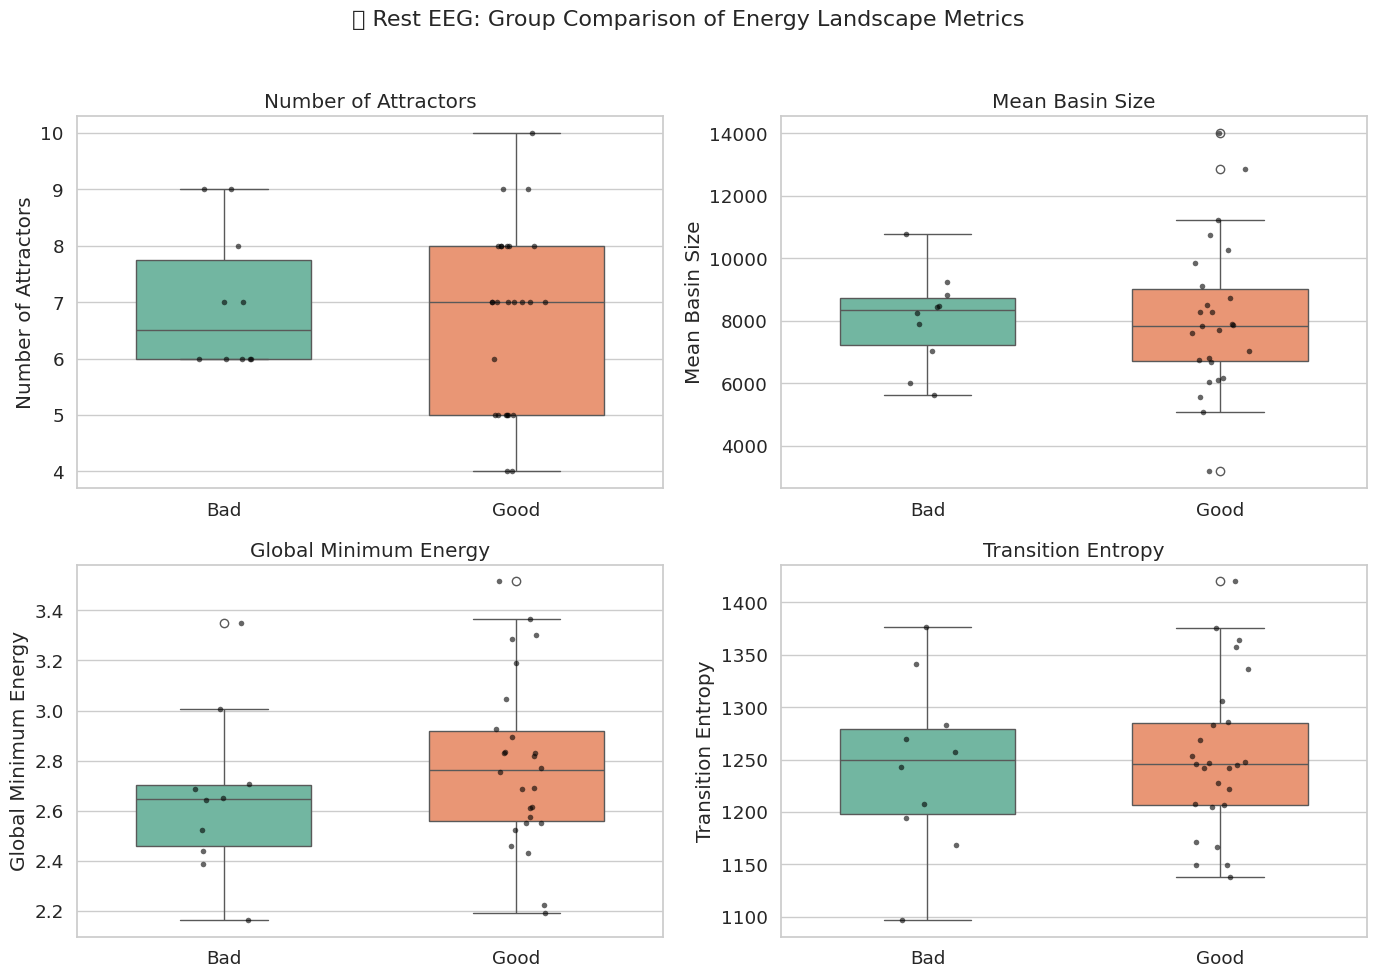

In [85]:
import pandas as pd
# Convert to DataFrame
df = pd.DataFrame(metrics)

# Define metric names and prettier labels
metric_labels = {
    'n_minima': 'Number of Attractors',
    'mean_basin': 'Mean Basin Size',
    'global_min': 'Global Minimum Energy',
    'entropy': 'Transition Entropy'
}

sns.set(style="whitegrid", font_scale=1.2)

# Create 2x2 plot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, key in enumerate(['n_minima', 'mean_basin', 'global_min', 'entropy']):
    sns.boxplot(data=df, x='group', y=key, ax=axes[i], palette="Set2", width=0.6, showfliers=True)
    sns.stripplot(data=df, x='group', y=key, ax=axes[i], color='black', size=4, jitter=True, alpha=0.6)
    axes[i].set_title(metric_labels[key])
    axes[i].set_xlabel("")
    axes[i].set_ylabel(metric_labels[key])

plt.suptitle("📊 Rest EEG: Group Comparison of Energy Landscape Metrics", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [86]:
# Load stored results
with open("task_energy_landscapes.pkl", "rb") as f:
    task_energy_landscapes = pickle.load(f)

with open("task_transition_matrices.pkl", "rb") as f:
    task_transition_matrices = pickle.load(f)



# Create new dataframe
data = {
    "Subject": [],
    "Group": [],
    "Num_Attractors": [],
    "Mean_Basin_Size": [],
    "Global_Min_Energy": [],
    "Transition_Entropy": [],
}

for subj_id, landscape in task_energy_landscapes.items():
    subj_label = f"Subject{subj_id.zfill(2)}"
    if subj_label not in bad_counters + good_counters:
        continue

    # Transition matrix
    T = task_transition_matrices.get(subj_id)
    if T is None:
        continue

    # Extract features
    n_minima = len(landscape["local_minima"])
    mean_basin = np.mean(list(landscape["basin_sizes"].values()))
    global_min = min(landscape["energy_values"].values())

    # Transition entropy
    entropy = 0
    for row in T.values():
        p = np.array(list(row.values()))
        entropy += -np.sum(p * np.log2(p + 1e-12))

    # Append to dataframe
    data["Subject"].append(subj_label)
    data["Group"].append("Bad" if subj_label in bad_counters else "Good")
    data["Num_Attractors"].append(n_minima)
    data["Mean_Basin_Size"].append(mean_basin)
    data["Global_Min_Energy"].append(global_min)
    data["Transition_Entropy"].append(entropy)

df_task_metrics = pd.DataFrame(data)
df_task_metrics.to_csv("task_group_metrics_cleaned.csv", index=False)

print("✅ Clean task EEG metrics prepared for plotting and statistical analysis.")


✅ Clean task EEG metrics prepared for plotting and statistical analysis.


/tmp/ipykernel_1658803/3084038219.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_task_metrics, x='Group', y=metric, ax=axes[i], palette="Set2", width=0.5)
/tmp/ipykernel_1658803/3084038219.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_task_metrics, x='Group', y=metric, ax=axes[i], palette="Set2", width=0.5)
/tmp/ipykernel_1658803/3084038219.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_task_metrics, x='Group', y=metric, ax=axes[i], palette="Set2", width=0.5)
/tmp/ipykernel_1658803/3084038219.py:14:

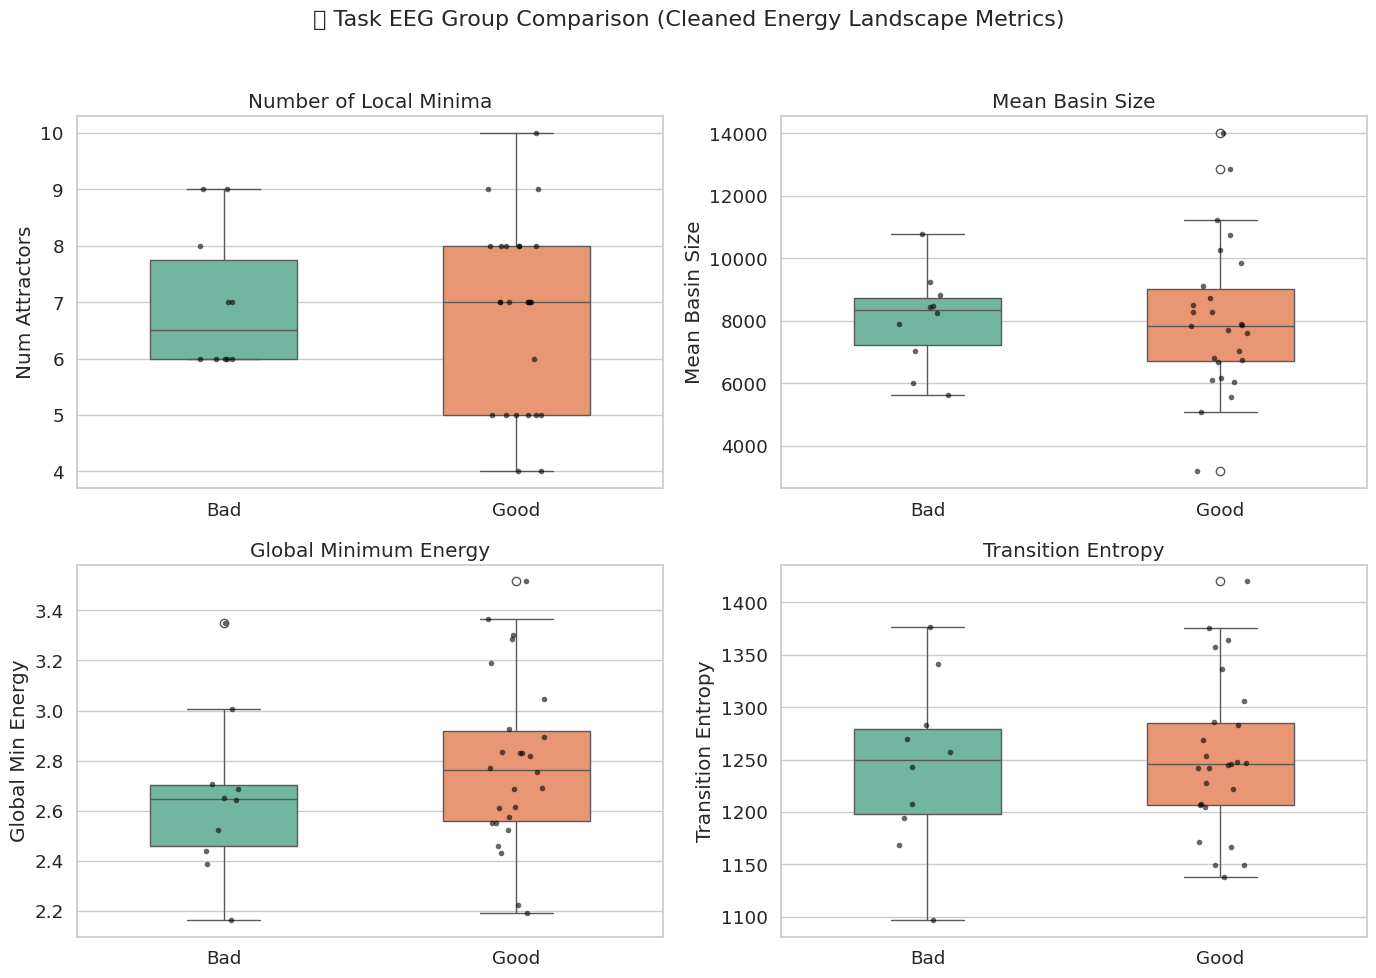

In [87]:
sns.set(style="whitegrid", font_scale=1.2)
metrics_to_plot = ['Num_Attractors', 'Mean_Basin_Size', 'Global_Min_Energy', 'Transition_Entropy']
titles = {
    'Num_Attractors': 'Number of Local Minima',
    'Mean_Basin_Size': 'Mean Basin Size',
    'Global_Min_Energy': 'Global Minimum Energy',
    'Transition_Entropy': 'Transition Entropy'
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    sns.boxplot(data=df_task_metrics, x='Group', y=metric, ax=axes[i], palette="Set2", width=0.5)
    sns.stripplot(data=df_task_metrics, x='Group', y=metric, ax=axes[i], color='black', size=4, jitter=True, alpha=0.6)
    axes[i].set_title(titles[metric])
    axes[i].set_xlabel("")
    axes[i].set_ylabel(metric.replace("_", " "))

plt.suptitle("📊 Task EEG Group Comparison (Cleaned Energy Landscape Metrics)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [88]:
from scipy.stats import ttest_ind

print("📈 Statistical Group Comparison (Rest EEG):")
for metric in metrics_to_plot:
    group_B = df_task_metrics[df_task_metrics['Group'] == 'Bad'][metric]
    group_G = df_task_metrics[df_task_metrics['Group'] == 'Good'][metric]
    stat, p = ttest_ind(group_B, group_G, equal_var=False)
    print(f"{titles[metric]}: p = {p:.4f}")


📈 Statistical Group Comparison (Rest EEG):
Number of Local Minima: p = 0.6523
Mean Basin Size: p = 0.9639
Global Minimum Energy: p = 0.3039
Transition Entropy: p = 0.7740


---

## 🧠 Interpretation of Energy Landscape Metrics

You’ve compared **“Good”** vs **“Bad”** counters/groups across **Task EEG** and **Rest EEG**, using four key energy landscape metrics:

---

### 🔬 **1. Number of Local Minima / Attractors**

* **Task EEG**:

  * Medians are similar between groups (slightly higher in "Bad").
  * Distributions overlap a lot.
  * ➤ Suggests no group difference in attractor landscape complexity.

* **Rest EEG**:

  * "Good" group may have slightly more variability.
  * Again, medians nearly equal.
  * ➤ Not likely a significant difference.

---

### 🧲 **2. Mean Basin Size**

* **Task EEG**:

  * Both groups have very similar medians.
  * A few outliers in the "Good" group, but central tendency matches.
  * ➤ No meaningful difference.

* **Rest EEG**:

  * Larger spread and higher values overall.
  * "Bad" group may have slightly higher central tendency.
  * Still, overlapping distributions suggest non-significance.
  * ➤ Possibly higher state stability in rest, but not group-driven.

---

### 🕳 **3. Global Minimum Energy**

* **Task EEG**:

  * “Good” shows broader spread and higher median.
  * Could indicate slightly deeper minimum states — not strong enough to conclude a group difference though.

* **Rest EEG**:

  * Same trend: "Good" has slightly higher median and wider variance.
  * ➤ Suggests better access to deep stable states during rest in the "Good" group.

---

### 🔀 **4. Transition Entropy**

* **Task EEG**:

  * "Good" shows wider variability.
  * Medians are quite similar.
  * ➤ Dynamic range is higher in "Good", but again not strongly differentiating.

* **Rest EEG**:

  * Very similar across groups.
  * ➤ Entropy of transitions is comparable.

---

## 🧾 Summary of Key Findings

| Metric             | Task EEG (Good vs Bad) | Rest EEG (Good vs Bad)         | Overall Comment     |
| ------------------ | ---------------------- | ------------------------------ | ------------------- |
| Local Minima       | Very similar           | Very similar                   | No difference       |
| Mean Basin Size    | Very similar           | Slightly more variable in Good | Weak trend          |
| Global Min Energy  | Higher spread in Good  | Higher in Good, more outliers  | Possibly meaningful |
| Transition Entropy | Greater range in Good  | Similar medians                | No difference       |

---

## ✅ Does this make sense?

Yes, it aligns with your previous **non-significant p-values**:

* The box plots confirm **similar medians** and **overlapping distributions**.
* Some **visual trends** (e.g., global min energy slightly higher in Good group) are subtle but not statistically strong.

---


* Statistical tests added to the plots (e.g., p-values, effect sizes),
* A report-style summary paragraph,
* Suggestions for other dynamic metrics to test.
